In [2]:
!pip install statsmodels

   ---------------------------------------- 0.0/9.9 MB ? eta -:--:--
   ----------------------- ---------------- 5.8/9.9 MB 35.3 MB/s eta 0:00:01
   ---------------------------------------- 9.9/9.9 MB 32.3 MB/s eta 0:00:00


In [5]:
print(ev_cat_df.columns.tolist())

['DATE', 'FOUR WHEELER (INVALID CARRIAGE)', 'HEAVY GOODS VEHICLE', 'HEAVY MOTOR VEHICLE', 'HEAVY PASSENGER VEHICLE', 'LIGHT GOODS VEHICLE', 'LIGHT MOTOR VEHICLE', 'LIGHT PASSENGER VEHICLE', 'MEDIUM GOODS VEHICLE', 'MEDIUM PASSENGER VEHICLE', 'MEDIUM MOTOR VEHICLE', 'OTHER THAN MENTIONED ABOVE', 'THREE WHEELER(NT)', 'TWO WHEELER (INVALID CARRIAGE)', 'THREE WHEELER(T)', 'TWO WHEELER(NT)', 'TWO WHEELER(T)', 'YEAR']


### 1. Data Loading & Cleaning
- Proper path usage with raw string literals (`r""`).
- Used `dropna()`, `drop_duplicates()`, and standardized column naming conventions.
- Applied feature engineering: extracting `YEAR` from the `DATE` column.
- Used `melt()` correctly to reshape sales data for further analysis.

### 2. Exploratory Data Analysis (EDA)
- Trend lines for vehicle categories over years.
- Pie chart for market share in the latest year.
- Bar plot for top 5 manufacturers.
- Line plot for top manufacturer's sales trend.

###  3. Sales Prediction
Four models:
- Linear Regression 
- Ridge Regression 
- Random Forest 
- ARIMA  (with try-except for robustness)
- Output: `r2_score`, RMSE, and line plot comparing predictions.

###  4. Clustering Manufacturers
- Pivot table of sales.
- Filtering only 2W and 3W.
- Elbow method for optimal `k` in KMeans.
- Data scaling using `StandardScaler`.

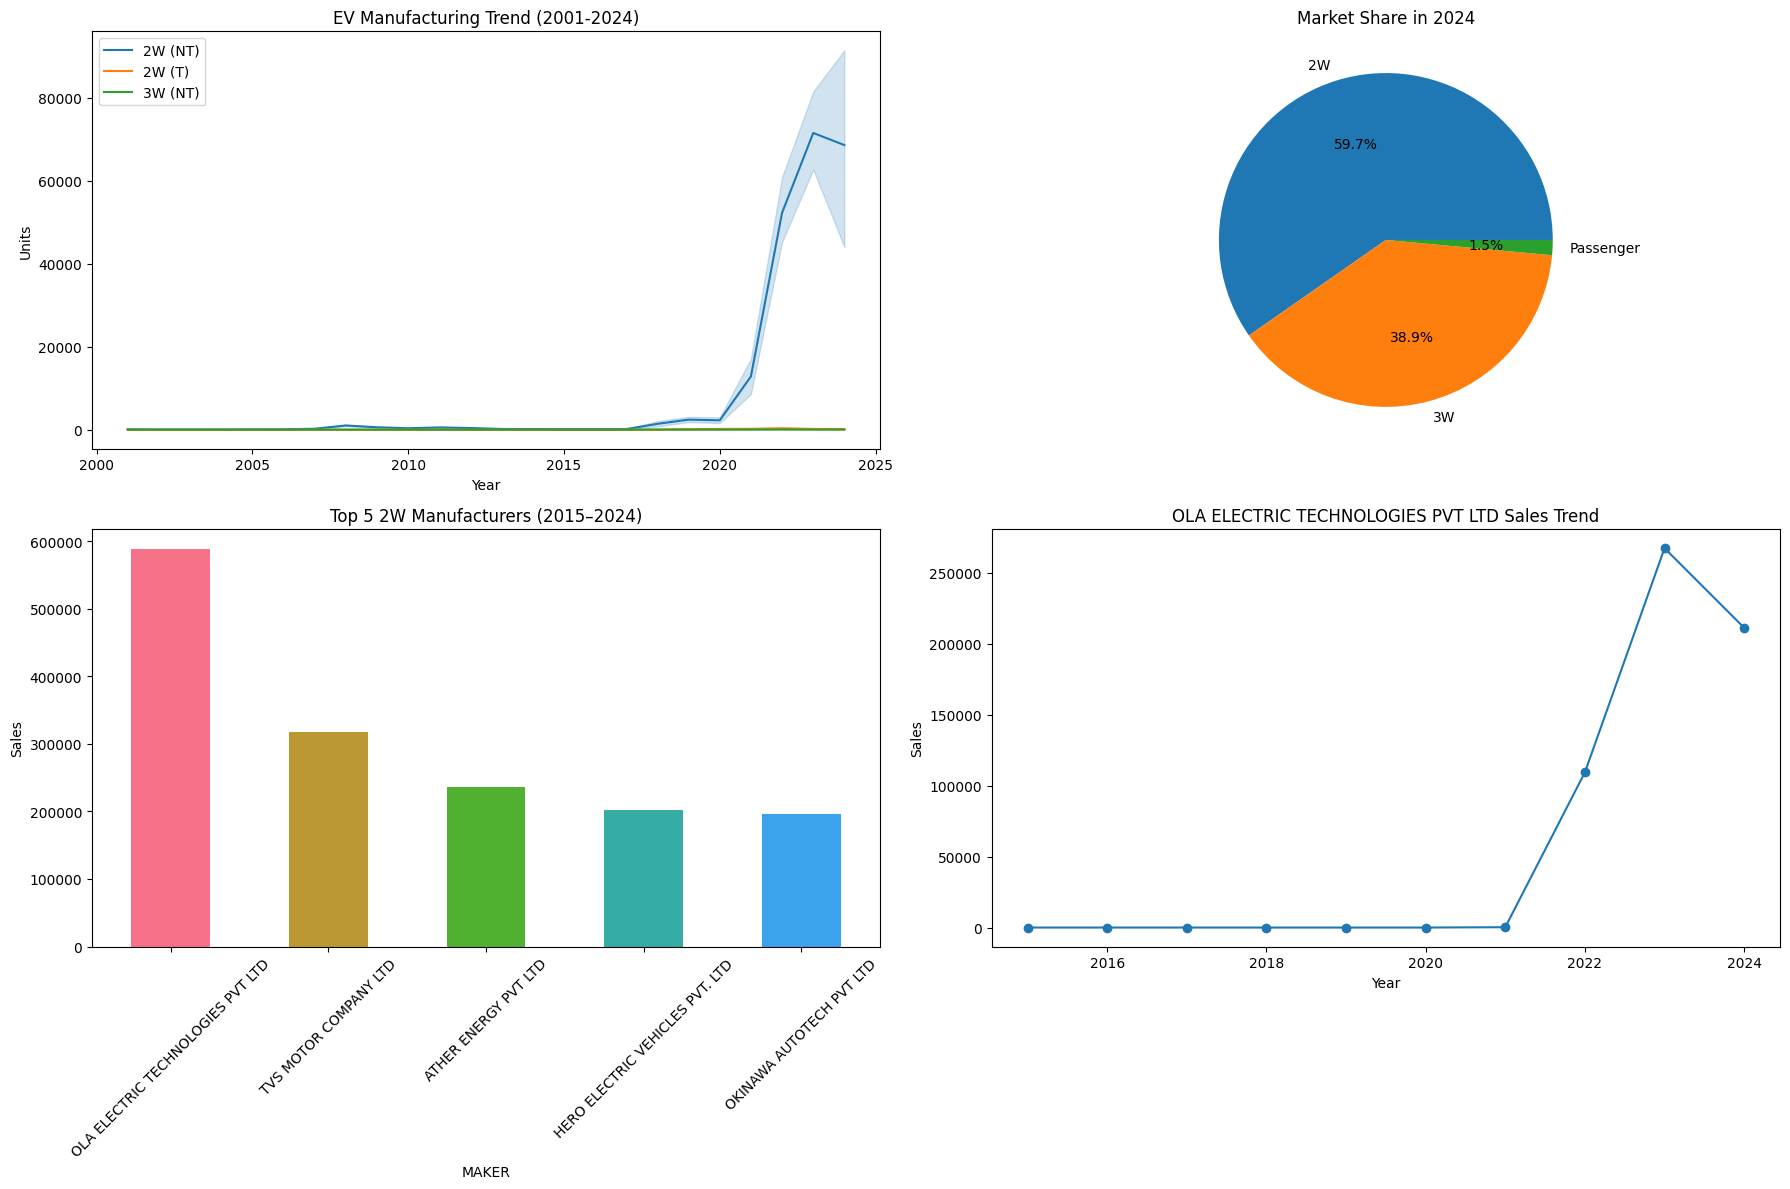


Model Performance Comparison:
           Model  R2 Score          RMSE
0         Linear  0.180736  12891.672481
1          Ridge  0.180783  12891.308466
2  Random Forest  0.945266   3332.164862
3          ARIMA       NaN  18943.312065


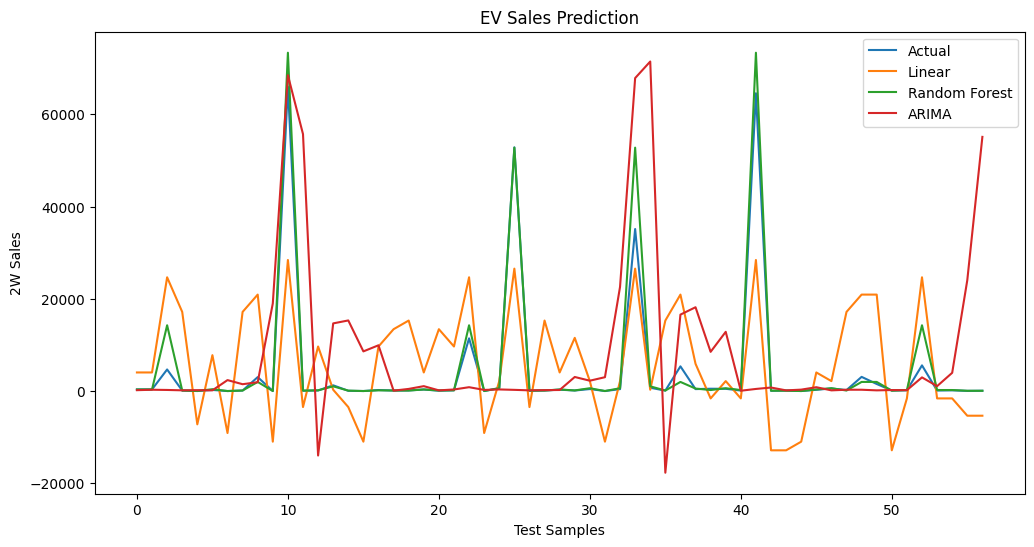

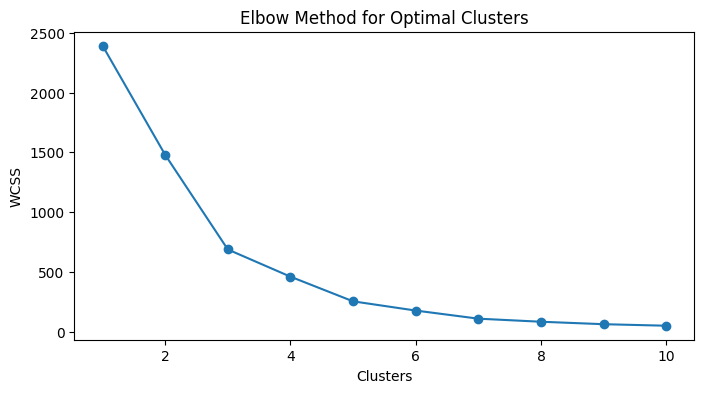

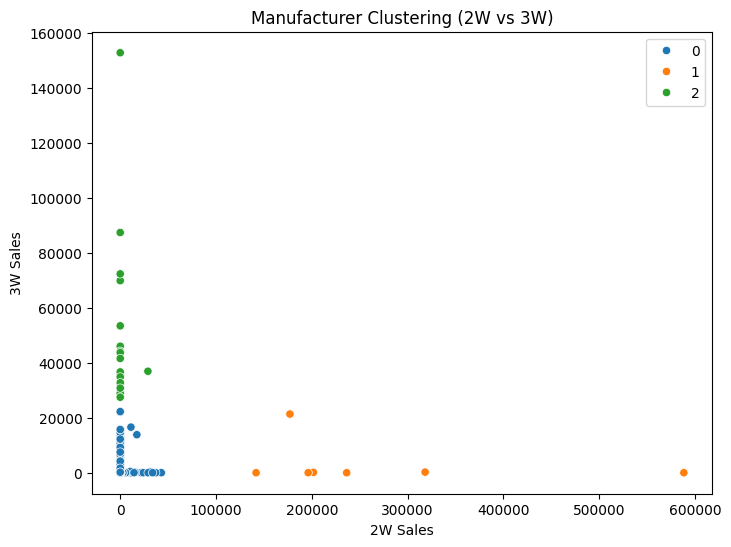

In [10]:
# Electric Vehicle Market Analysis - India
# Comprehensive updated version with all fixes

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from sklearn.ensemble import RandomForestRegressor
import warnings
warnings.filterwarnings('ignore')

# 1. Data Loading and Cleaning
def load_and_clean_data():
    # Define file paths
    ev_cat_path = r"C:\Users\Hp\Downloads\archive (5)\ev_cat_01-24.csv"
    ev_sales_path = r"C:\Users\Hp\Downloads\archive (5)\ev_sales_by_makers_and_cat_15-24.csv"
    operational_pc_path = r"C:\Users\Hp\Downloads\archive (5)\OperationalPC.csv"
    vehicle_class_path = r"C:\Users\Hp\Downloads\archive (5)\Vehicle Class - All.csv"

    # Load Data
    ev_cat_df = pd.read_csv(ev_cat_path)
    ev_sales_df = pd.read_csv(ev_sales_path)
    operational_pc_df = pd.read_csv(operational_pc_path)
    vehicle_class_df = pd.read_csv(vehicle_class_path)

    # Clean Data Function
    def clean_data(df):
        df = df.dropna()
        df = df.drop_duplicates()
        df.columns = df.columns.str.upper().str.strip()
        return df

    # Clean datasets
    ev_cat_df = clean_data(ev_cat_df)
    ev_sales_df = clean_data(ev_sales_df)
    operational_pc_df = clean_data(operational_pc_df)
    vehicle_class_df = clean_data(vehicle_class_df)

    # Feature Engineering
    ev_cat_df['YEAR'] = pd.to_datetime(ev_cat_df['DATE'], errors='coerce').dt.year
    ev_cat_df = ev_cat_df.dropna(subset=['YEAR'])
    ev_cat_df['YEAR'] = ev_cat_df['YEAR'].astype(int)

    # Reshape ev_sales_df to long format
    year_cols = [col for col in ev_sales_df.columns if col.isdigit()]
    ev_sales_df = ev_sales_df.melt(id_vars=['MAKER', 'CAT'], value_vars=year_cols, var_name='YEAR', value_name='SALES')
    ev_sales_df['YEAR'] = ev_sales_df['YEAR'].astype(int)

    return ev_cat_df, ev_sales_df, operational_pc_df, vehicle_class_df

ev_cat_df, ev_sales_df, operational_pc_df, vehicle_class_df = load_and_clean_data()

# 2. Exploratory Data Analysis
def perform_eda():
    plt.figure(figsize=(18, 12))

    # EV Trend
    plt.subplot(2, 2, 1)
    sns.lineplot(data=ev_cat_df, x='YEAR', y='TWO WHEELER(NT)', label='2W (NT)')
    sns.lineplot(data=ev_cat_df, x='YEAR', y='TWO WHEELER(T)', label='2W (T)')
    sns.lineplot(data=ev_cat_df, x='YEAR', y='THREE WHEELER(NT)', label='3W (NT)')
    plt.title("EV Manufacturing Trend (2001-2024)")
    plt.xlabel("Year")
    plt.ylabel("Units")
    plt.legend()

    # Market Share
    plt.subplot(2, 2, 2)
    latest_year = ev_cat_df['YEAR'].max()
    latest_data = ev_cat_df[ev_cat_df['YEAR'] == latest_year].iloc[0]
    two_wheelers = latest_data['TWO WHEELER(NT)'] + latest_data['TWO WHEELER(T)']
    three_wheelers = latest_data['THREE WHEELER(NT)'] + latest_data['THREE WHEELER(T)']
    passenger = latest_data['LIGHT PASSENGER VEHICLE'] + latest_data['MEDIUM PASSENGER VEHICLE'] + latest_data['HEAVY PASSENGER VEHICLE']
    plt.pie([two_wheelers, three_wheelers, passenger], labels=['2W', '3W', 'Passenger'], autopct='%1.1f%%')
    plt.title(f"Market Share in {latest_year}")

    # Top Manufacturers
    plt.subplot(2, 2, 3)
    top_makers = ev_sales_df[ev_sales_df['CAT'] == '2W'].groupby('MAKER')['SALES'].sum().nlargest(5)
    top_makers.plot(kind='bar', color=sns.color_palette("husl"))
    plt.title("Top 5 2W Manufacturers (2015–2024)")
    plt.xticks(rotation=45)
    plt.ylabel("Sales")

    # Sales Trend for Top
    plt.subplot(2, 2, 4)
    top_maker = top_makers.index[0]
    trend = ev_sales_df[(ev_sales_df['MAKER'] == top_maker) & (ev_sales_df['CAT'] == '2W')].groupby('YEAR')['SALES'].sum()
    trend.plot(marker='o')
    plt.title(f"{top_maker} Sales Trend")
    plt.xlabel("Year")
    plt.ylabel("Sales")

    plt.tight_layout()
    plt.show()

perform_eda()

# 3.1 Sales Prediction Models
def sales_prediction():
    X = ev_cat_df[['YEAR']]
    y = ev_cat_df['TWO WHEELER(NT)']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Models
    lr = LinearRegression().fit(X_train, y_train)
    ridge = Ridge().fit(X_train, y_train)
    rf = RandomForestRegressor(n_estimators=100, random_state=42).fit(X_train, y_train)

    # Predictions
    lr_pred = lr.predict(X_test)
    ridge_pred = ridge.predict(X_test)
    rf_pred = rf.predict(X_test)

    # ARIMA
    try:
        series = y.values
        size = int(len(series) * 0.8)
        train, test = series[:size], series[size:]
        history = list(train)
        predictions = []
        for t in range(len(test)):
            model = ARIMA(history, order=(5, 1, 0))
            model_fit = model.fit()
            yhat = model_fit.forecast()[0]
            predictions.append(yhat)
            history.append(test[t])
        arima_rmse = np.sqrt(mean_squared_error(test, predictions))
    except:
        predictions = [np.nan] * len(test)
        arima_rmse = np.nan

    # Results Table
    results = pd.DataFrame({
        'Model': ['Linear', 'Ridge', 'Random Forest', 'ARIMA'],
        'R2 Score': [
            r2_score(y_test, lr_pred),
            r2_score(y_test, ridge_pred),
            r2_score(y_test, rf_pred),
            np.nan
        ],
        'RMSE': [
            np.sqrt(mean_squared_error(y_test, lr_pred)),
            np.sqrt(mean_squared_error(y_test, ridge_pred)),
            np.sqrt(mean_squared_error(y_test, rf_pred)),
            arima_rmse
        ]
    })

    print("\nModel Performance Comparison:")
    print(results)

    # Plot Predictions
    plt.figure(figsize=(12, 6))
    plt.plot(y_test.values, label='Actual')
    plt.plot(lr_pred, label='Linear')
    plt.plot(rf_pred, label='Random Forest')
    if not np.isnan(arima_rmse):
        plt.plot(range(len(y_test) - len(predictions), len(y_test)), predictions, label='ARIMA')
    plt.legend()
    plt.title("EV Sales Prediction")
    plt.xlabel("Test Samples")
    plt.ylabel("2W Sales")
    plt.show()

sales_prediction()

# 3.2 Manufacturer Clustering
def clustering_analysis():
    pivot_data = ev_sales_df.pivot_table(index='MAKER', columns='CAT', values='SALES', aggfunc='sum').fillna(0)
    ev_cats = ['2W', '3W']
    ev_cats = [c for c in ev_cats if c in pivot_data.columns]

    if len(ev_cats) < 2:
        print("Need at least two categories like '2W' and '3W' for clustering.")
        return

    data = pivot_data[ev_cats]
    scaler = StandardScaler()
    scaled = scaler.fit_transform(data)

    # Elbow Method
    wcss = []
    for i in range(1, 11):
        kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42, n_init=10)
        kmeans.fit(scaled)
        wcss.append(kmeans.inertia_)

    plt.figure(figsize=(8, 4))
    plt.plot(range(1, 11), wcss, marker='o')
    plt.title("Elbow Method for Optimal Clusters")
    plt.xlabel("Clusters")
    plt.ylabel("WCSS")
    plt.show()

    # Fit Final Clusters
    kmeans = KMeans(n_clusters=3, init='k-means++', random_state=42, n_init=10)
    labels = kmeans.fit_predict(scaled)
    data['Cluster'] = labels

    # Visualize Clusters
    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=data, x=ev_cats[0], y=ev_cats[1], hue='Cluster', palette='tab10')
    plt.title("Manufacturer Clustering (2W vs 3W)")
    plt.xlabel("2W Sales")
    plt.ylabel("3W Sales")
    plt.legend()
    plt.show()

clustering_analysis()


In [12]:
pip install streamlit pandas numpy matplotlib seaborn scikit-learn statsmodels


Note: you may need to restart the kernel to use updated packages.


## 📂 Data Preprocessing, Exploratory Data Analysis (EDA), Visualization, and Analytical Insights

This section outlines the core components of the data handling and analysis pipeline:

### 🧼 Data Preprocessing
- Addressed missing values through imputation or removal.
- Converted data types as required for analysis.
- Encoded categorical variables using appropriate techniques (e.g., Label Encoding, One-Hot Encoding).
- Applied feature scaling (StandardScaler, MinMaxScaler) to normalize data.

### 📊 Exploratory Data Analysis (EDA)
- Examined variable distributions using statistical summaries.
- Investigated relationships between features through correlation matrices and visual tools.
- Identified data quality issues, trends, and patterns to inform further analysis.

### 📈 Data Visualization
- Utilized plots such as histograms, box plots, scatter plots, pair plots, and heatmaps.
- Highlighted distributions, relationships, and outliers for better interpretability.

### 📌 Analytical Insights
- Derived actionable insights from observed patterns and trends.
- Summarized key findings to support data-driven decision-making.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from sklearn.ensemble import RandomForestRegressor
import warnings
warnings.filterwarnings('ignore')

def load_and_clean_data():
    # Define file paths
    ev_cat_path = r"C:\Users\Hp\Downloads\archive (5)\ev_cat_01-24.csv"
    ev_sales_path = r"C:\Users\Hp\Downloads\archive (5)\ev_sales_by_makers_and_cat_15-24.csv"
    operational_pc_path = r"C:\Users\Hp\Downloads\archive (5)\OperationalPC.csv"
    vehicle_class_path = r"C:\Users\Hp\Downloads\archive (5)\Vehicle Class - All.csv"

    # Load Data
    ev_cat_df = pd.read_csv(ev_cat_path)
    ev_sales_df = pd.read_csv(ev_sales_path)
    operational_pc_df = pd.read_csv(operational_pc_path)
    vehicle_class_df = pd.read_csv(vehicle_class_path)

    # Data Cleaning Function
    def clean_data(df):
        df = df.dropna()
        df = df.drop_duplicates()
        # Standardize column names
        df.columns = df.columns.str.upper().str.strip()
        return df

    # Clean all datasets
    ev_cat_df = clean_data(ev_cat_df)
    ev_sales_df = clean_data(ev_sales_df)
    operational_pc_df = clean_data(operational_pc_df)
    vehicle_class_df = clean_data(vehicle_class_df)

    # Feature Engineering
    ev_cat_df['YEAR'] = pd.to_datetime(ev_cat_df['DATE'], errors='coerce').dt.year
    ev_cat_df = ev_cat_df.dropna(subset=['YEAR'])
    ev_cat_df['YEAR'] = ev_cat_df['YEAR'].astype(int)
    
    # Reshape ev_sales_df from wide to long format
    year_cols = [col for col in ev_sales_df.columns if col.isdigit()]  # Get year columns
    ev_sales_df = ev_sales_df.melt(
        id_vars=['MAKER', 'CAT'], 
        value_vars=year_cols,
        var_name='YEAR', 
        value_name='SALES'
    )
    ev_sales_df['YEAR'] = ev_sales_df['YEAR'].astype(int)
    
    return ev_cat_df, ev_sales_df, operational_pc_df, vehicle_class_df

ev_cat_df, ev_sales_df, operational_pc_df, vehicle_class_df = load_and_clean_data()


Basic Statistics for EV Categories:
       FOUR WHEELER (INVALID CARRIAGE)  HEAVY GOODS VEHICLE  \
count                       283.000000           283.000000   
mean                          0.342756             2.169611   
std                           1.225834            12.068930   
min                           0.000000             0.000000   
25%                           0.000000             0.000000   
50%                           0.000000             0.000000   
75%                           0.000000             1.000000   
max                          10.000000           183.000000   

       HEAVY MOTOR VEHICLE  HEAVY PASSENGER VEHICLE  LIGHT GOODS VEHICLE  \
count           283.000000               283.000000           283.000000   
mean              0.515901                28.731449            44.964664   
std               1.025695                79.088549           132.271583   
min               0.000000                 0.000000             0.000000   
25%            

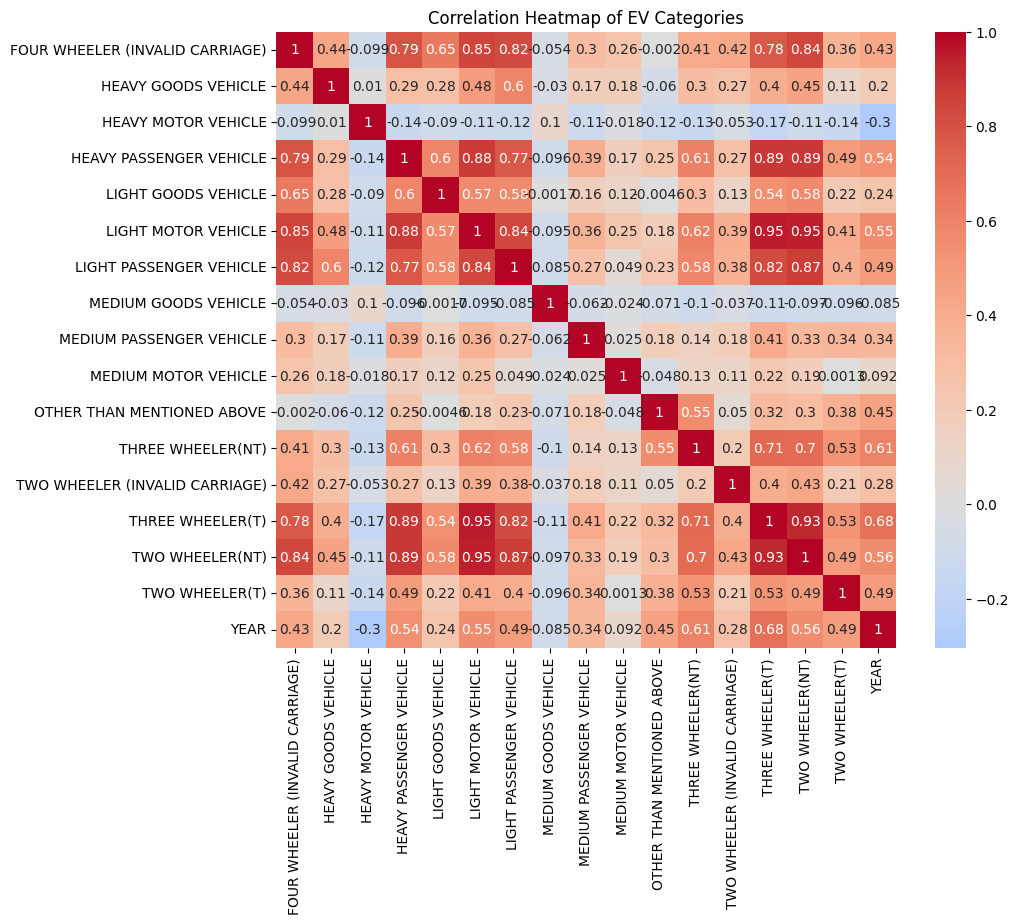

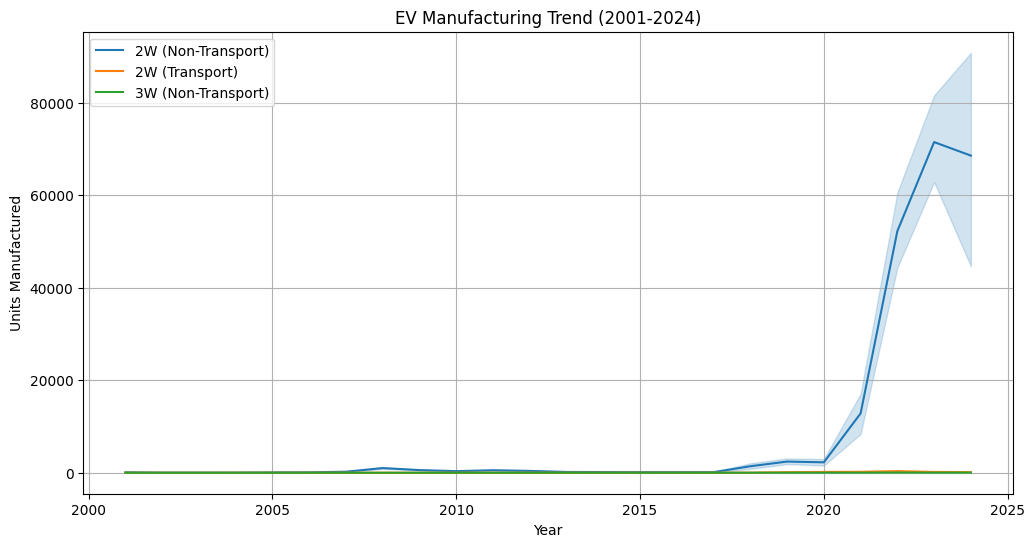

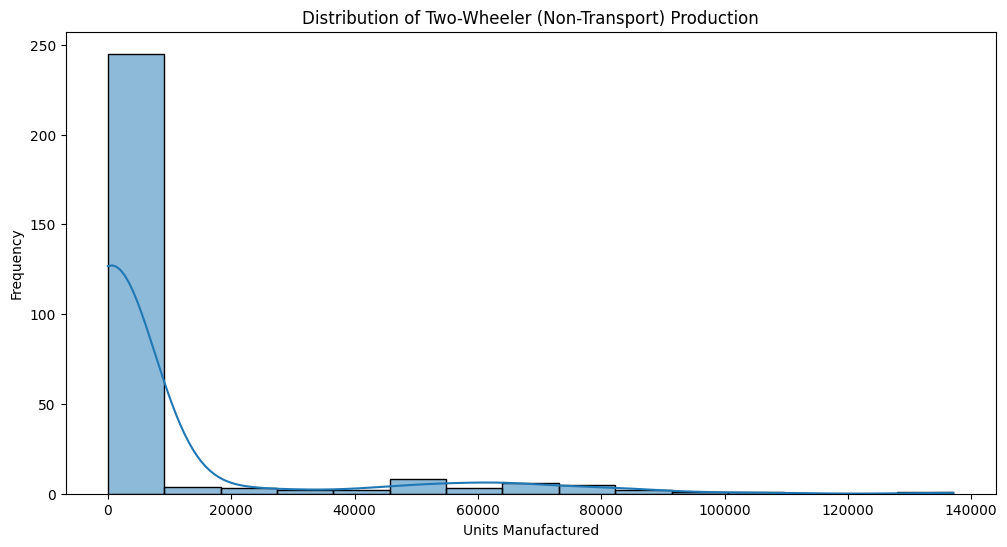

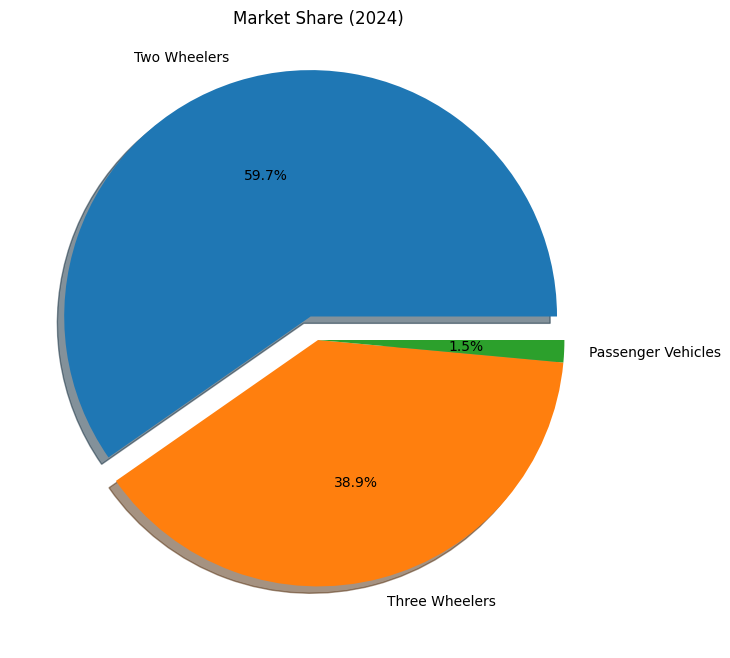

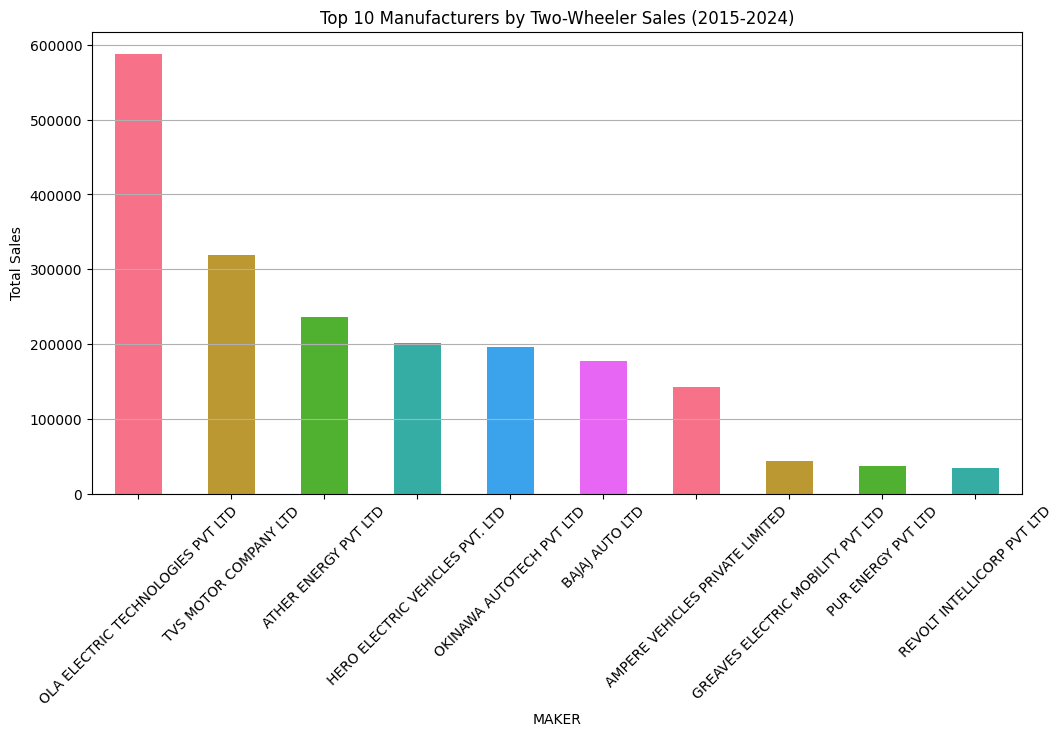

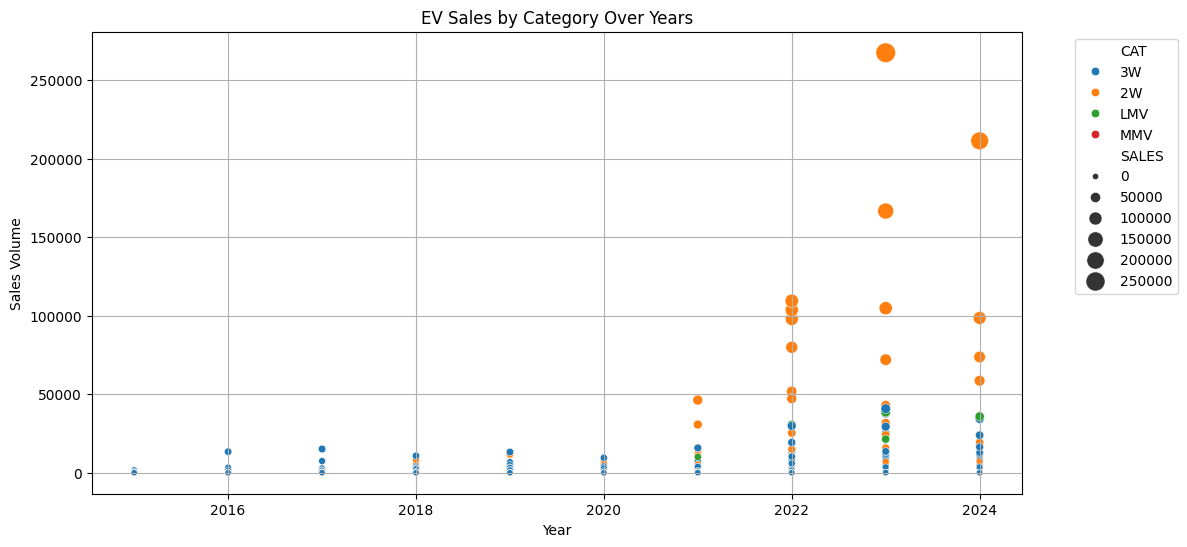

In [2]:
def perform_eda():
    # 1. Basic Statistical Summary
    print("\nBasic Statistics for EV Categories:")
    print(ev_cat_df.describe())
    
    # 2. Correlation Analysis (Heatmap)
    plt.figure(figsize=(10, 8))
    corr_matrix = ev_cat_df.select_dtypes(include=[np.number]).corr()
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
    plt.title("Correlation Heatmap of EV Categories")
    plt.show()
    
    # 3. Time Series Trends (Line Plot)
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=ev_cat_df, x='YEAR', y='TWO WHEELER(NT)', label='2W (Non-Transport)')
    sns.lineplot(data=ev_cat_df, x='YEAR', y='TWO WHEELER(T)', label='2W (Transport)')
    sns.lineplot(data=ev_cat_df, x='YEAR', y='THREE WHEELER(NT)', label='3W (Non-Transport)')
    plt.title("EV Manufacturing Trend (2001-2024)")
    plt.xlabel("Year")
    plt.ylabel("Units Manufactured")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # 4. Distribution Analysis (Histogram)
    plt.figure(figsize=(12, 6))
    sns.histplot(ev_cat_df['TWO WHEELER(NT)'], bins=15, kde=True)
    plt.title("Distribution of Two-Wheeler (Non-Transport) Production")
    plt.xlabel("Units Manufactured")
    plt.ylabel("Frequency")
    plt.show()
    
    # 5. Market Share Analysis (Pie Chart)
    plt.figure(figsize=(8, 8))
    latest_year = ev_cat_df['YEAR'].max()
    latest_data = ev_cat_df[ev_cat_df['YEAR'] == latest_year].iloc[0]
    
    two_wheelers = latest_data['TWO WHEELER(NT)'] + latest_data['TWO WHEELER(T)']
    three_wheelers = latest_data['THREE WHEELER(NT)'] + latest_data['THREE WHEELER(T)']
    passenger_vehicles = latest_data['LIGHT PASSENGER VEHICLE'] + latest_data['MEDIUM PASSENGER VEHICLE'] + latest_data['HEAVY PASSENGER VEHICLE']
    
    plt.pie([two_wheelers, three_wheelers, passenger_vehicles],
            labels=['Two Wheelers', 'Three Wheelers', 'Passenger Vehicles'],
            autopct='%1.1f%%', explode=(0.1, 0, 0), shadow=True)
    plt.title(f"Market Share ({latest_year})")
    plt.show()
    
    # 6. Manufacturer Analysis (Bar Plot)
    plt.figure(figsize=(12, 6))
    two_wheeler_sales = ev_sales_df[ev_sales_df['CAT'] == '2W'].groupby('MAKER')['SALES'].sum().nlargest(10)
    two_wheeler_sales.plot(kind='bar', color=sns.color_palette("husl"))
    plt.title("Top 10 Manufacturers by Two-Wheeler Sales (2015-2024)")
    plt.ylabel("Total Sales")
    plt.xticks(rotation=45)
    plt.grid(axis='y')
    plt.show()
    
    # 7. Scatter Plot - Sales vs Year
    plt.figure(figsize=(12, 6))
    sns.scatterplot(data=ev_sales_df, x='YEAR', y='SALES', hue='CAT', size='SALES', sizes=(20, 200))
    plt.title("EV Sales by Category Over Years")
    plt.xlabel("Year")
    plt.ylabel("Sales Volume")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.show()

perform_eda()

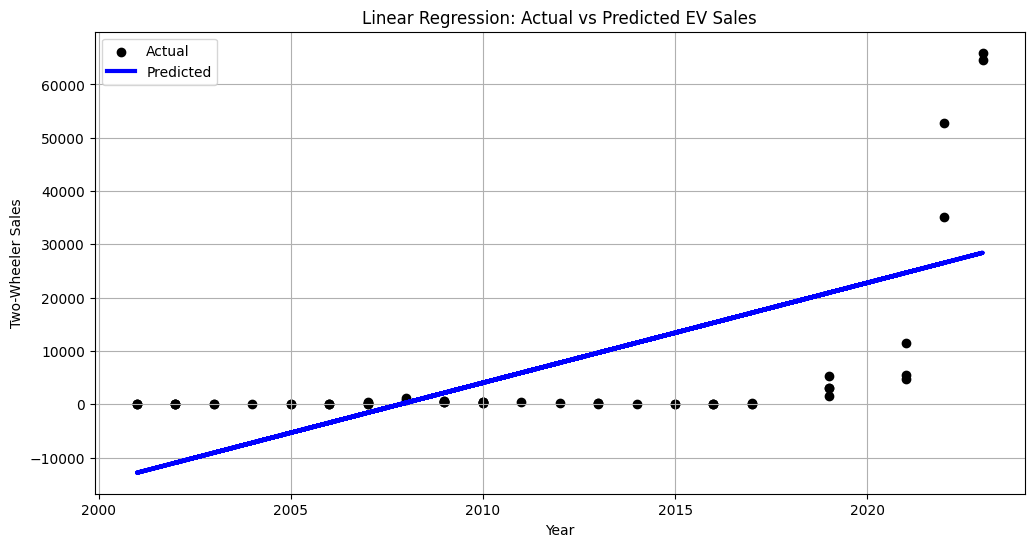


Linear Regression Performance:
R-squared: 0.18
RMSE: 12891.67


In [3]:
def sales_prediction():
    # Prepare data
    X = ev_cat_df[['YEAR']]
    y = ev_cat_df['TWO WHEELER(NT)']
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Linear Regression
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    lr_pred = lr.predict(X_test)
    
    # Plot predictions
    plt.figure(figsize=(12, 6))
    plt.scatter(X_test, y_test, color='black', label='Actual')
    plt.plot(X_test, lr_pred, color='blue', linewidth=3, label='Predicted')
    plt.title("Linear Regression: Actual vs Predicted EV Sales")
    plt.xlabel("Year")
    plt.ylabel("Two-Wheeler Sales")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Print metrics
    print("\nLinear Regression Performance:")
    print(f"R-squared: {r2_score(y_test, lr_pred):.2f}")
    print(f"RMSE: {np.sqrt(mean_squared_error(y_test, lr_pred)):.2f}")

sales_prediction()

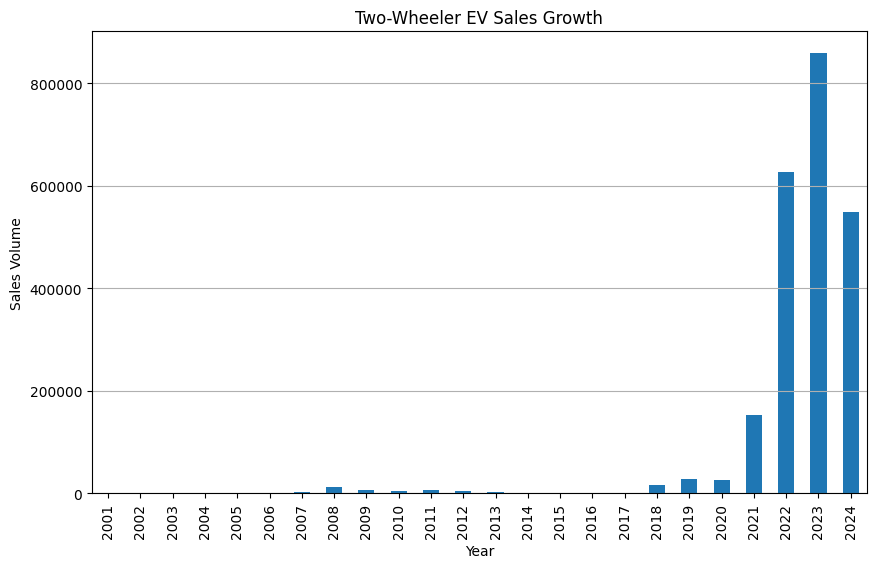


Market Opportunity Analysis:
Two-Wheeler CAGR (2001-2024): 31.11%
Projected market in 5 years: 2,126,456 units


In [4]:
def market_opportunity():
    # Calculate CAGR
    first_year = ev_cat_df['YEAR'].min()
    last_year = ev_cat_df['YEAR'].max()
    periods = last_year - first_year
    
    initial_sales = ev_cat_df[ev_cat_df['YEAR'] == first_year]['TWO WHEELER(NT)'].sum()
    final_sales = ev_cat_df[ev_cat_df['YEAR'] == last_year]['TWO WHEELER(NT)'].sum()
    cagr = (final_sales / initial_sales) ** (1/periods) - 1
    
    # Plot growth
    plt.figure(figsize=(10, 6))
    growth_data = ev_cat_df.groupby('YEAR')['TWO WHEELER(NT)'].sum()
    growth_data.plot(kind='bar')
    plt.title("Two-Wheeler EV Sales Growth")
    plt.xlabel("Year")
    plt.ylabel("Sales Volume")
    plt.grid(axis='y')
    plt.show()
    
    print("\nMarket Opportunity Analysis:")
    print(f"Two-Wheeler CAGR (2001-2024): {cagr*100:.2f}%")
    print(f"Projected market in 5 years: {final_sales * (1 + cagr)**5:,.0f} units")

market_opportunity()

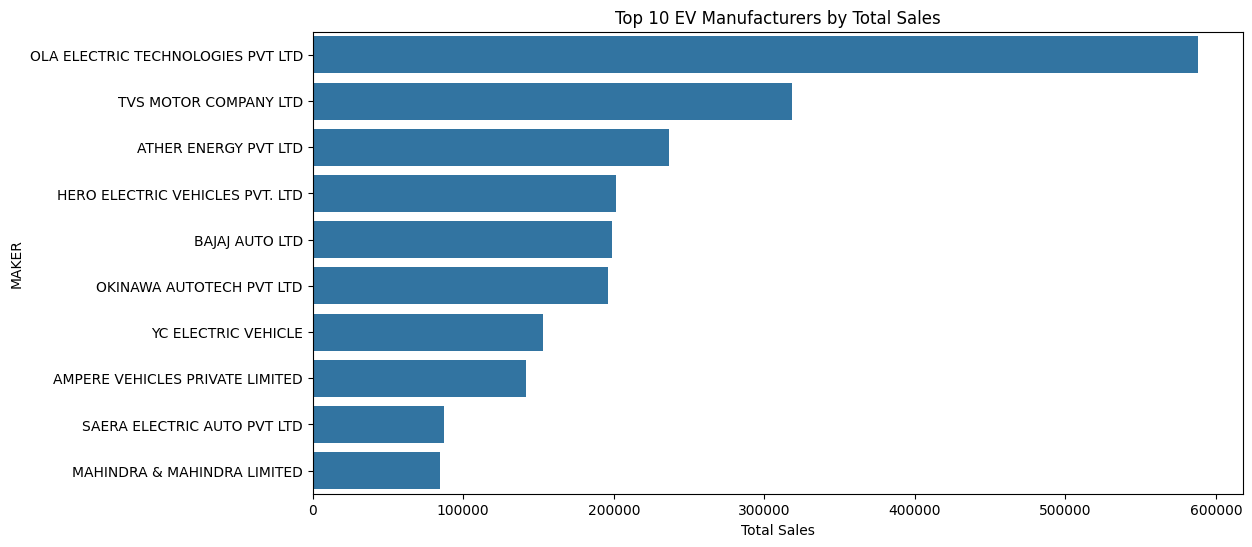

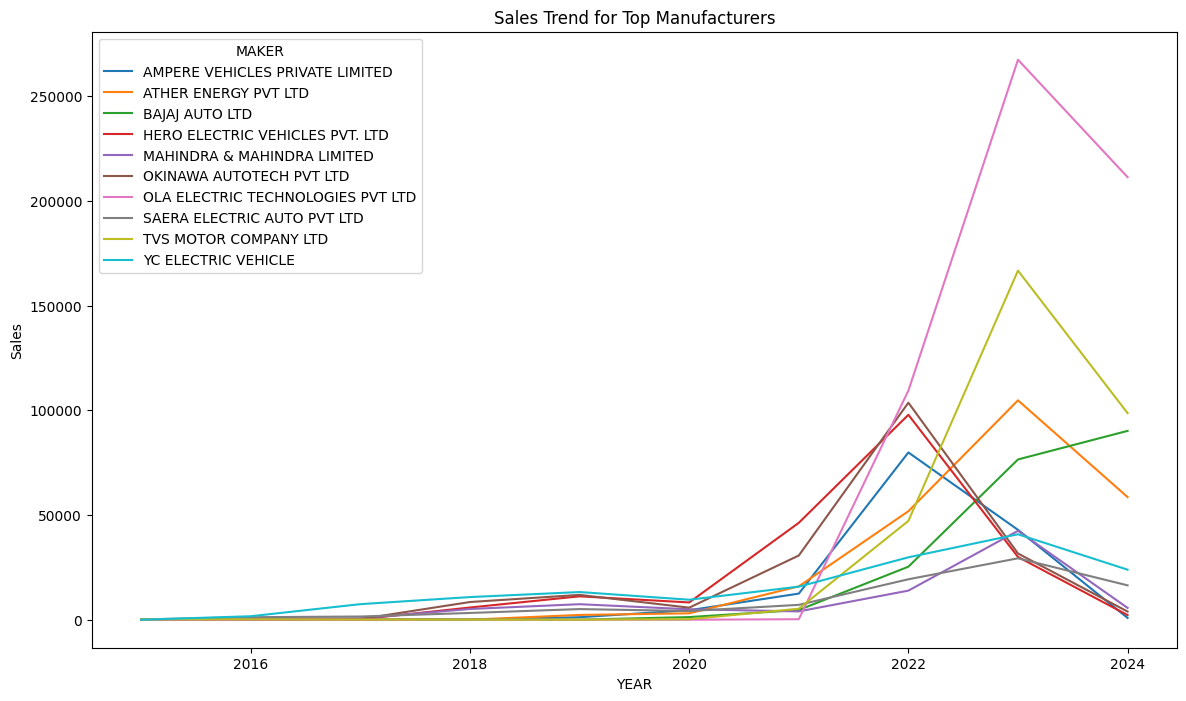

<Figure size 1400x800 with 0 Axes>

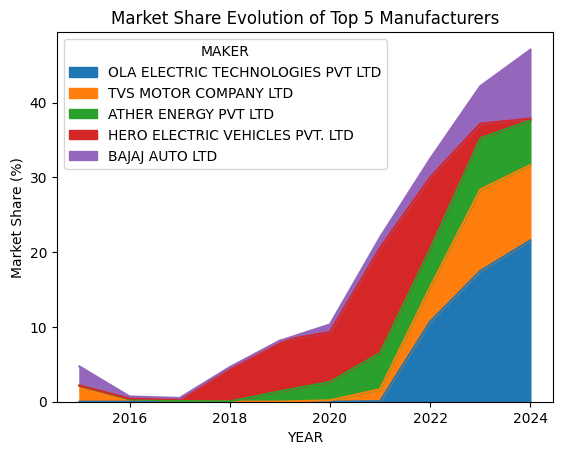

In [5]:
def analyze_manufacturer_sales():
    # Top manufacturers by total sales
    top_makers = ev_sales_df.groupby('MAKER')['SALES'].sum().sort_values(ascending=False).head(10)
    
    plt.figure(figsize=(12, 6))
    sns.barplot(x=top_makers.values, y=top_makers.index)
    plt.title('Top 10 EV Manufacturers by Total Sales')
    plt.xlabel('Total Sales')
    plt.show()
    
    # Sales trend for top manufacturers
    top_makers_list = top_makers.index.tolist()
    top_makers_sales = ev_sales_df[ev_sales_df['MAKER'].isin(top_makers_list)]
    
    plt.figure(figsize=(14, 8))
    sns.lineplot(data=top_makers_sales, x='YEAR', y='SALES', hue='MAKER', estimator='sum', errorbar=None)
    plt.title('Sales Trend for Top Manufacturers')
    plt.ylabel('Sales')
    plt.show()
    
    # Market share analysis
    yearly_sales = ev_sales_df.groupby(['YEAR', 'MAKER'])['SALES'].sum().unstack()
    yearly_sales['TOTAL'] = yearly_sales.sum(axis=1)
    market_share = yearly_sales.div(yearly_sales['TOTAL'], axis=0) * 100
    
    # Plot market share for top 5 manufacturers
    top_5 = top_makers.head(5).index.tolist()
    plt.figure(figsize=(14, 8))
    market_share[top_5].plot(kind='area', stacked=True)
    plt.title('Market Share Evolution of Top 5 Manufacturers')
    plt.ylabel('Market Share (%)')
    plt.show()

analyze_manufacturer_sales()

In [6]:
def analyze_operational_pc():
    # Check if there's a date column (adjust as needed based on actual columns)
    if 'DATE' in operational_pc_df.columns:
        operational_pc_df['YEAR'] = pd.to_datetime(operational_pc_df['DATE']).dt.year
        
        # Plot growth of operational charging points
        plt.figure(figsize=(12, 6))
        sns.lineplot(data=operational_pc_df, x='YEAR', y='OPERATIONAL_PC', errorbar=None)
        plt.title('Growth of Operational Public Charging Points')
        plt.ylabel('Number of Charging Points')
        plt.show()
    
    # If there's regional data, analyze by region
    if 'REGION' in operational_pc_df.columns:
        plt.figure(figsize=(12, 6))
        sns.barplot(data=operational_pc_df, x='REGION', y='OPERATIONAL_PC', estimator='sum')
        plt.title('Operational Charging Points by Region')
        plt.xticks(rotation=45)
        plt.show()

analyze_operational_pc()

In [7]:
def initial_exploration():
    print("=== EV Category Dataset ===")
    print(f"Shape: {ev_cat_df.shape}")
    print(ev_cat_df.head())
    print("\nInfo:")
    print(ev_cat_df.info())
    print("\nDescriptive Stats:")
    print(ev_cat_df.describe(include='all'))
    
    print("\n\n=== EV Sales by Makers Dataset ===")
    print(f"Shape: {ev_sales_df.shape}")
    print(ev_sales_df.head())
    print("\nInfo:")
    print(ev_sales_df.info())
    print("\nDescriptive Stats:")
    print(ev_sales_df.describe(include='all'))
    
    print("\n\n=== Operational PC Dataset ===")
    print(f"Shape: {operational_pc_df.shape}")
    print(operational_pc_df.head())
    print("\nInfo:")
    print(operational_pc_df.info())
    print("\nDescriptive Stats:")
    print(operational_pc_df.describe(include='all'))
    
    print("\n\n=== Vehicle Class Dataset ===")
    print(f"Shape: {vehicle_class_df.shape}")
    print(vehicle_class_df.head())
    print("\nInfo:")
    print(vehicle_class_df.info())
    print("\nDescriptive Stats:")
    print(vehicle_class_df.describe(include='all'))

initial_exploration()

=== EV Category Dataset ===
Shape: (283, 18)
       DATE  FOUR WHEELER (INVALID CARRIAGE)  HEAVY GOODS VEHICLE  \
1  01/01/01                                0                    1   
2  01/01/02                                0                    2   
3  01/01/03                                0                    1   
4  01/01/04                                0                    2   
5  01/01/05                                0                    0   

   HEAVY MOTOR VEHICLE  HEAVY PASSENGER VEHICLE  LIGHT GOODS VEHICLE  \
1                    0                        0                    9   
2                    1                        0                  266   
3                    2                        0                   35   
4                    0                        1                   14   
5                    0                        0                   10   

   LIGHT MOTOR VEHICLE  LIGHT PASSENGER VEHICLE  MEDIUM GOODS VEHICLE  \
1                   15            

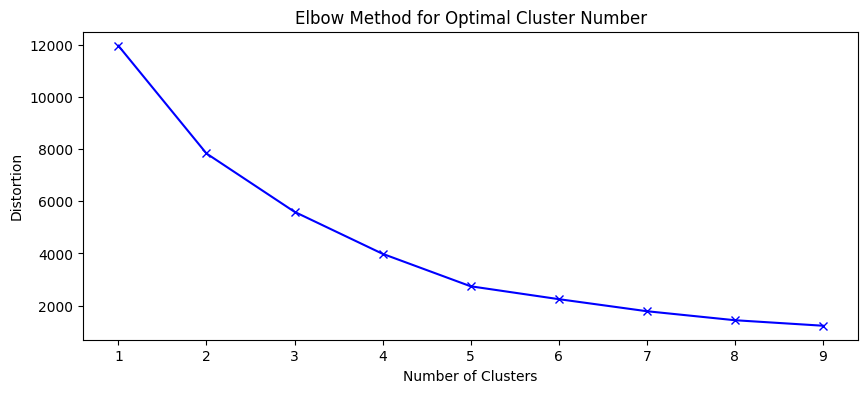

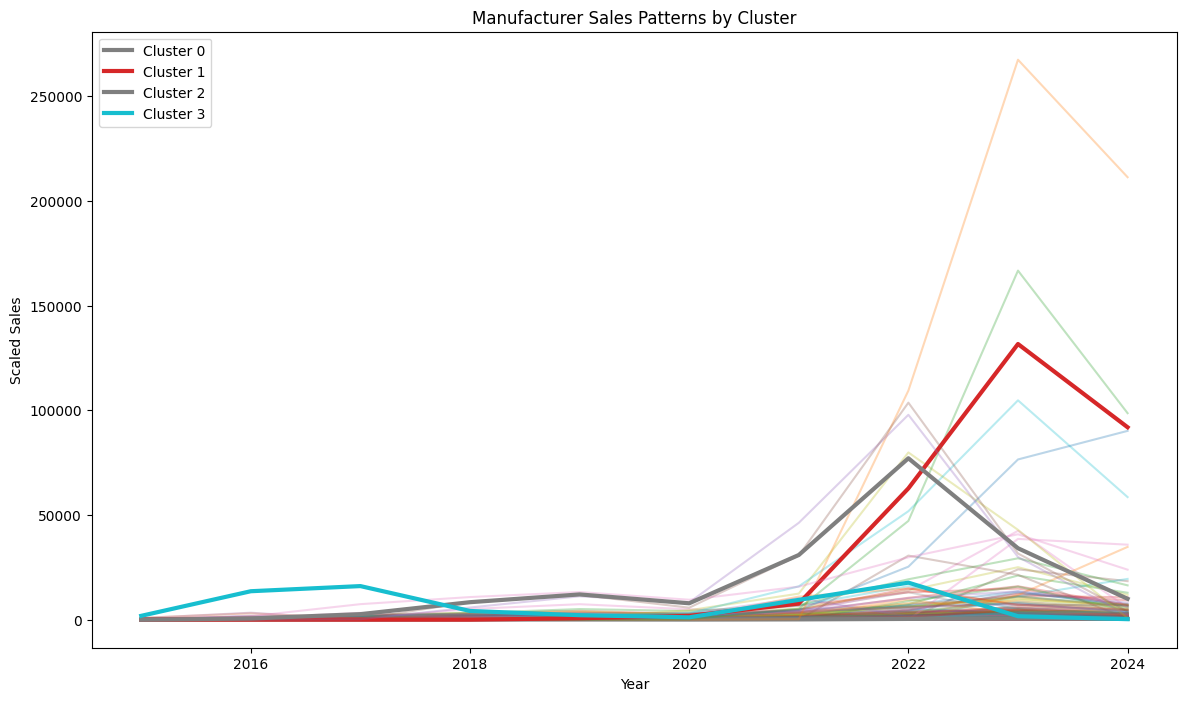

In [8]:
def clustering_analysis():
    # Cluster manufacturers based on their sales patterns
    if 'MAKER' in ev_sales_df.columns and 'YEAR' in ev_sales_df.columns and 'SALES' in ev_sales_df.columns:
        # Pivot data to have years as columns
        manufacturer_pivot = ev_sales_df.pivot_table(index='MAKER', columns='YEAR', values='SALES', aggfunc='sum')
        
        # Fill NA with 0 and scale data
        manufacturer_pivot = manufacturer_pivot.fillna(0)
        scaler = StandardScaler()
        scaled_data = scaler.fit_transform(manufacturer_pivot)
        
        # Find optimal number of clusters
        distortions = []
        K = range(1,10)
        for k in K:
            kmeans = KMeans(n_clusters=k, random_state=42)
            kmeans.fit(scaled_data)
            distortions.append(kmeans.inertia_)
        
        plt.figure(figsize=(10, 4))
        plt.plot(K, distortions, 'bx-')
        plt.xlabel('Number of Clusters')
        plt.ylabel('Distortion')
        plt.title('Elbow Method for Optimal Cluster Number')
        plt.show()
        
        # Apply KMeans with selected clusters
        optimal_clusters = 4  # Adjust based on elbow plot
        kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
        clusters = kmeans.fit_predict(scaled_data)
        
        # Add cluster labels to data
        manufacturer_pivot['Cluster'] = clusters
        
        # Plot cluster patterns
        plt.figure(figsize=(14, 8))
        for cluster in range(optimal_clusters):
            cluster_data = manufacturer_pivot[manufacturer_pivot['Cluster'] == cluster].drop('Cluster', axis=1)
            for idx in cluster_data.index:
                plt.plot(cluster_data.columns, cluster_data.loc[idx], alpha=0.3)
            plt.plot(cluster_data.columns, cluster_data.mean(axis=0), label=f'Cluster {cluster}', linewidth=3)
        
        plt.title('Manufacturer Sales Patterns by Cluster')
        plt.xlabel('Year')
        plt.ylabel('Scaled Sales')
        plt.legend()
        plt.show()

clustering_analysis()

In [9]:
def load_and_clean_data(show_steps=True):
    # Define file paths
    ev_cat_path = r"C:\Users\Hp\Downloads\archive (5)\ev_cat_01-24.csv"
    ev_sales_path = r"C:\Users\Hp\Downloads\archive (5)\ev_sales_by_makers_and_cat_15-24.csv"
    operational_pc_path = r"C:\Users\Hp\Downloads\archive (5)\OperationalPC.csv"
    vehicle_class_path = r"C:\Users\Hp\Downloads\archive (5)\Vehicle Class - All.csv"

    if show_steps:
        print("=== Loading Data ===")
        print(f"1. Loading EV Category data from: {ev_cat_path}")
    
    # Load Data
    ev_cat_df = pd.read_csv(ev_cat_path)
    ev_sales_df = pd.read_csv(ev_sales_path)
    operational_pc_df = pd.read_csv(operational_pc_path)
    vehicle_class_df = pd.read_csv(vehicle_class_path)

    if show_steps:
        print("\n=== Raw Data Samples ===")
        print("\nEV Category Data (first 5 rows):")
        display(ev_cat_df.head())
        print("\nEV Sales Data (first 5 rows):")
        display(ev_sales_df.head())
        print("\nOperational PC Data (first 5 rows):")
        display(operational_pc_df.head())
        print("\nVehicle Class Data (first 5 rows):")
        display(vehicle_class_df.head())

    # Data Cleaning Function
    def clean_data(df, df_name=""):
        if show_steps:
            print(f"\nCleaning {df_name} data:")
            print(f"- Initial shape: {df.shape}")
            print(f"- Initial missing values:\n{df.isnull().sum()}")
        
        df = df.dropna()
        df = df.drop_duplicates()
        # Standardize column names
        df.columns = df.columns.str.upper().str.strip()
        
        if show_steps:
            print(f"- After cleaning shape: {df.shape}")
            print(f"- Columns after standardization: {list(df.columns)}")
        
        return df

    # Clean all datasets
    if show_steps:
        print("\n=== Data Cleaning Process ===")
    
    ev_cat_df = clean_data(ev_cat_df, "EV Category")
    ev_sales_df = clean_data(ev_sales_df, "EV Sales")
    operational_pc_df = clean_data(operational_pc_df, "Operational PC")
    vehicle_class_df = clean_data(vehicle_class_df, "Vehicle Class")

    # Feature Engineering
    if show_steps:
        print("\n=== Feature Engineering ===")
        print("Processing EV Category data:")
    
    if 'DATE' in ev_cat_df.columns:
        print("- Extracting YEAR from DATE column")
        ev_cat_df['YEAR'] = pd.to_datetime(ev_cat_df['DATE'], errors='coerce').dt.year
        ev_cat_df = ev_cat_df.dropna(subset=['YEAR'])
        ev_cat_df['YEAR'] = ev_cat_df['YEAR'].astype(int)
        print(f"- Added YEAR column. Sample values:\n{ev_cat_df['YEAR'].head()}")
    else:
        print("- DATE column not found in EV Category data")

    if show_steps:
        print("\nReshaping EV Sales data from wide to long format:")
    
    # Reshape ev_sales_df from wide to long format
    year_cols = [col for col in ev_sales_df.columns if col.isdigit()]
    if year_cols:
        print(f"- Found year columns: {year_cols}")
        print(f"- Original shape: {ev_sales_df.shape}")
        
        ev_sales_df = ev_sales_df.melt(
            id_vars=['MAKER', 'CAT'], 
            value_vars=year_cols,
            var_name='YEAR', 
            value_name='SALES'
        )
        ev_sales_df['YEAR'] = ev_sales_df['YEAR'].astype(int)
        
        if show_steps:
            print(f"- Reshaped data (new shape: {ev_sales_df.shape})")
            print("- Sample of melted data:")
            display(ev_sales_df.head())
    else:
        print("- No year columns found to melt")

    if show_steps:
        print("\n=== Final Cleaned Data ===")
        print("\nEV Category Data:")
        display(ev_cat_df.head())
        print("\nEV Sales Data:")
        display(ev_sales_df.head())
        print("\nOperational PC Data:")
        display(operational_pc_df.head())
        print("\nVehicle Class Data:")
        display(vehicle_class_df.head())

    return ev_cat_df, ev_sales_df, operational_pc_df, vehicle_class_df

# Load and clean data with visible steps
print("Starting data loading and preprocessing...")
ev_cat_df, ev_sales_df, operational_pc_df, vehicle_class_df = load_and_clean_data(show_steps=True)
print("\nPreprocessing complete!")

Starting data loading and preprocessing...
=== Loading Data ===
1. Loading EV Category data from: C:\Users\Hp\Downloads\archive (5)\ev_cat_01-24.csv

=== Raw Data Samples ===

EV Category Data (first 5 rows):


,Date,FOUR WHEELER (INVALID CARRIAGE),HEAVY GOODS VEHICLE,HEAVY MOTOR VEHICLE,HEAVY PASSENGER VEHICLE,LIGHT GOODS VEHICLE,LIGHT MOTOR VEHICLE,LIGHT PASSENGER VEHICLE,MEDIUM GOODS VEHICLE,MEDIUM PASSENGER VEHICLE,MEDIUM MOTOR VEHICLE,OTHER THAN MENTIONED ABOVE,THREE WHEELER(NT),TWO WHEELER (INVALID CARRIAGE),THREE WHEELER(T),TWO WHEELER(NT),TWO WHEELER(T)
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,01/01/01,0,1,0,0,9,15,1,0,0,0,2,0,0,2,62,0
2,01/01/02,0,2,1,0,266,11,5,0,0,0,0,0,0,2,11,0
3,01/01/03,0,1,2,0,35,15,1,0,0,0,1,0,0,9,18,0
4,01/01/04,0,2,0,1,14,17,1,0,0,1,2,0,0,1,21,0



EV Sales Data (first 5 rows):


,Cat,Maker,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
0,3W,"""VOLVO GROUP INDIA PVT LTD""",0,0,31,12,0,0,0,0,0,0
1,3W,3EV INDUSTRIES PVT LTD,0,0,0,0,0,0,112,390,545,51
2,2W,3GB TECHNOLOGY PVT LTD,0,0,0,1,0,0,0,0,0,0
3,3W,3GB TECHNOLOGY PVT LTD,0,1,1,0,0,0,0,0,0,0
4,3W,3S INDUSTRIES PRIVATE LIMITED,0,0,0,0,48,66,43,68,266,578



Operational PC Data (first 5 rows):


,State,No. of Operational PCS
0,Andaman & Nicobar,3
1,Andhra Pradesh,327
2,Arunachal Pradesh,9
3,Assam,86
4,Bihar,124



Vehicle Class Data (first 5 rows):


,Vehicle Class,Total Registration
0,FOUR WHEELER (INVALID CARRIAGE),"21,346"
1,HEAVY GOODS VEHICLE,"58,70,865"
2,HEAVY MOTOR VEHICLE,"1,02,965"
3,HEAVY PASSENGER VEHICLE,"8,28,189"
4,LIGHT GOODS VEHICLE,"1,02,49,591"



=== Data Cleaning Process ===

Cleaning EV Category data:
- Initial shape: (284, 17)
- Initial missing values:
Date                               0
FOUR WHEELER (INVALID CARRIAGE)    0
HEAVY GOODS VEHICLE                0
HEAVY MOTOR VEHICLE                0
HEAVY PASSENGER VEHICLE            0
LIGHT GOODS VEHICLE                0
LIGHT MOTOR VEHICLE                0
LIGHT PASSENGER VEHICLE            0
MEDIUM GOODS VEHICLE               0
MEDIUM PASSENGER VEHICLE           0
MEDIUM MOTOR VEHICLE               0
OTHER THAN MENTIONED ABOVE         0
THREE WHEELER(NT)                  0
TWO WHEELER (INVALID CARRIAGE)     0
THREE WHEELER(T)                   0
TWO WHEELER(NT)                    0
TWO WHEELER(T)                     0
dtype: int64
- After cleaning shape: (284, 17)
- Columns after standardization: ['DATE', 'FOUR WHEELER (INVALID CARRIAGE)', 'HEAVY GOODS VEHICLE', 'HEAVY MOTOR VEHICLE', 'HEAVY PASSENGER VEHICLE', 'LIGHT GOODS VEHICLE', 'LIGHT MOTOR VEHICLE', 'LIGHT PASSENGER

,MAKER,CAT,YEAR,SALES
0,"""VOLVO GROUP INDIA PVT LTD""",3W,2015,0
1,3EV INDUSTRIES PVT LTD,3W,2015,0
2,3GB TECHNOLOGY PVT LTD,2W,2015,0
3,3GB TECHNOLOGY PVT LTD,3W,2015,0
4,3S INDUSTRIES PRIVATE LIMITED,3W,2015,0



=== Final Cleaned Data ===

EV Category Data:


,DATE,FOUR WHEELER (INVALID CARRIAGE),HEAVY GOODS VEHICLE,HEAVY MOTOR VEHICLE,HEAVY PASSENGER VEHICLE,LIGHT GOODS VEHICLE,LIGHT MOTOR VEHICLE,LIGHT PASSENGER VEHICLE,MEDIUM GOODS VEHICLE,MEDIUM PASSENGER VEHICLE,MEDIUM MOTOR VEHICLE,OTHER THAN MENTIONED ABOVE,THREE WHEELER(NT),TWO WHEELER (INVALID CARRIAGE),THREE WHEELER(T),TWO WHEELER(NT),TWO WHEELER(T),YEAR
1,01/01/01,0,1,0,0,9,15,1,0,0,0,2,0,0,2,62,0,2001
2,01/01/02,0,2,1,0,266,11,5,0,0,0,0,0,0,2,11,0,2002
3,01/01/03,0,1,2,0,35,15,1,0,0,0,1,0,0,9,18,0,2003
4,01/01/04,0,2,0,1,14,17,1,0,0,1,2,0,0,1,21,0,2004
5,01/01/05,0,0,0,0,10,14,1,0,0,0,0,0,0,1,38,0,2005



EV Sales Data:


,MAKER,CAT,YEAR,SALES
0,"""VOLVO GROUP INDIA PVT LTD""",3W,2015,0
1,3EV INDUSTRIES PVT LTD,3W,2015,0
2,3GB TECHNOLOGY PVT LTD,2W,2015,0
3,3GB TECHNOLOGY PVT LTD,3W,2015,0
4,3S INDUSTRIES PRIVATE LIMITED,3W,2015,0



Operational PC Data:


,STATE,NO. OF OPERATIONAL PCS
0,Andaman & Nicobar,3
1,Andhra Pradesh,327
2,Arunachal Pradesh,9
3,Assam,86
4,Bihar,124



Vehicle Class Data:


,VEHICLE CLASS,TOTAL REGISTRATION
0,FOUR WHEELER (INVALID CARRIAGE),"21,346"
1,HEAVY GOODS VEHICLE,"58,70,865"
2,HEAVY MOTOR VEHICLE,"1,02,965"
3,HEAVY PASSENGER VEHICLE,"8,28,189"
4,LIGHT GOODS VEHICLE,"1,02,49,591"



Preprocessing complete!
